# Writing data to EDITO private storage

## Install packages

In [32]:
packages = ['xarray',
            's3fs',
            'numpy',
            'cartopy',
            'matplotlib',
            'zarr'
           ]
for package in packages:
    !pip install {package} > /dev/null 2>&1
for package in packages:
    exec(f'import {package}')

## Import packages

In [33]:
import os
import s3fs
import zarr
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Create random data

In [34]:
# --- Create random raster dataset (10x10 with values 0-10) ---
data = np.random.randint(0, 11, size=(10, 10))

# Define geospatial coordinates
lon = np.linspace(0.5, 9.5, 10)   # pixel centers from 0 to 10E
lat = np.linspace(59.5, 50.5, 10) # pixel centers from 60N to 50N (north→south)

# Create DataArray with georeferencing
raster = xr.DataArray(
    data,
    dims=("lat", "lon"),
    coords={"lat": lat, "lon": lon},
    name="random_raster",
    attrs={"units": "arbitrary", "description": "Random 10x10 raster covering 0-10E, 50-60N"}
)

## Inspect the data

In [35]:
print(raster)

<xarray.DataArray 'random_raster' (lat: 10, lon: 10)> Size: 800B
array([[ 5,  8,  1,  0,  7,  6,  7,  0,  1,  1],
       [ 4,  4,  7, 10,  6,  0,  8, 10,  3,  2],
       [ 3,  6,  5,  7,  0,  5,  9,  6,  8,  6],
       [ 0,  0,  1,  4,  7,  1,  7,  5,  4,  3],
       [ 5,  1,  6,  5,  2,  6,  0,  4,  5,  9],
       [ 1,  3,  0,  7,  3,  8,  2,  9,  8,  2],
       [ 8,  5,  1, 10,  0,  8,  9,  0,  2,  9],
       [ 8,  5,  4, 10, 10,  3,  8,  1,  2,  2],
       [ 2,  5,  9, 10,  6,  7,  9,  7,  8,  8],
       [ 3,  3,  1,  1,  6,  7,  3, 10,  3,  4]])
Coordinates:
  * lat      (lat) float64 80B 59.5 58.5 57.5 56.5 55.5 54.5 53.5 52.5 51.5 50.5
  * lon      (lon) float64 80B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
Attributes:
    units:        arbitrary
    description:  Random 10x10 raster covering 0-10E, 50-60N


## Plot as a map

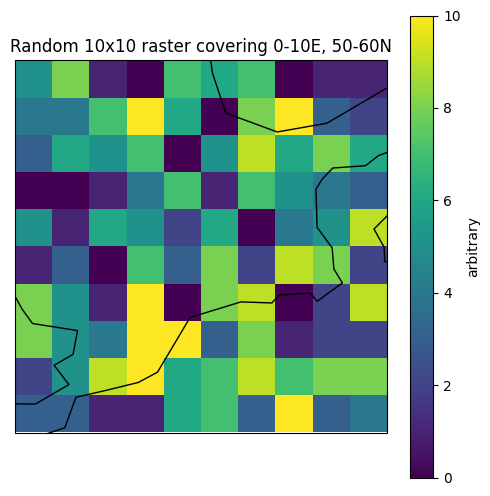

In [36]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

raster.plot(
    ax=ax,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": raster.attrs.get("units", "values")}
)

ax.coastlines(resolution="110m")
ax.set_extent([0, 10, 50, 60])  # [lon_min, lon_max, lat_min, lat_max]
ax.set_title(raster.attrs.get("description", "Raster dataset"))

plt.show()


## Set your credentials

You need to add your credentials in this piece of code.
> Copy paste this information from EDITO datalab > my account > connect to storage > we use s3fs in this tutorial

- Note that the credentials are 24h valid. 
- It is bad practice to store credentials in code.
-  Use a config file (e.g. .toml) and exclude it via .gitignore when working on real applications!

In [38]:
# --- Set credentials (replace with your actual values) ---
os.environ["AWS_ACCESS_KEY_ID"] = "YOUR_ACCESS_KEY"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YOUR_SECRET_KEY"
os.environ["AWS_SESSION_TOKEN"] = "YOUR_SESSION_TOKEN"
os.environ["AWS_DEFAULT_REGION"] = "waw3-1"

# --- Setup S3FS filesystem ---
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://' + 'minio.dive.edito.eu'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ["AWS_SESSION_TOKEN"],
)

## Write data to bucket

Make sure to change the zarr_path to your personal S3 space!

In [40]:
# Wrap into Dataset
ds = raster.to_dataset()

# --- Define S3/Zarr output path ---
zarr_path = f"oidc-willemboone/upload_data/random_raster1.zarr"

# --- Write dataset to Zarr in S3 ---
ds.to_zarr(
    store=fs.get_mapper(zarr_path),
    consolidated=True,
    mode="w"
)

print(f"✅ Georeferenced dataset written to s3://{zarr_path}")

✅ Georeferenced dataset written to s3://oidc-willemboone/upload_data/random_raster1.zarr


/opt/python/lib/python3.13/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
